importing Jupyter notebook from first_week.ipynb
48502


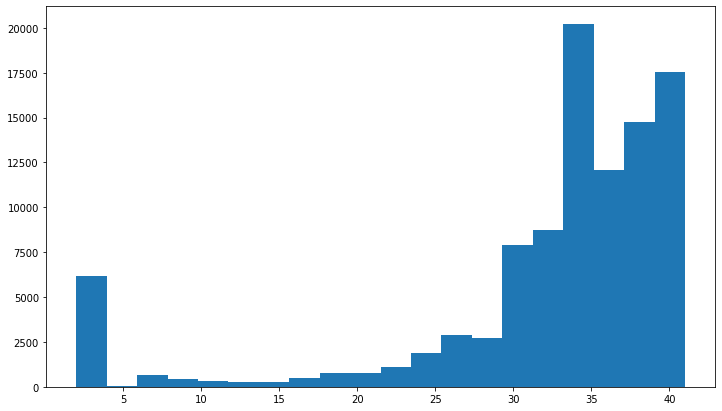

51
50
50
52


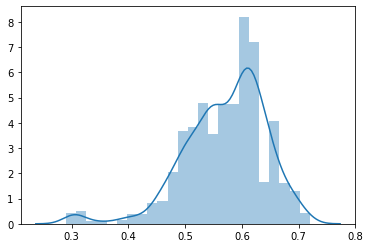

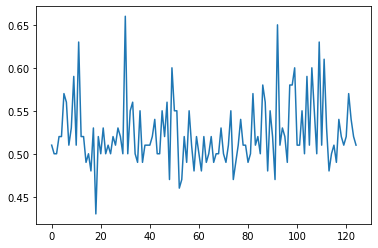

100 matches out of 100
7 matches out of 1000
0.10272407531738281


In [1]:
import import_ipynb
from first_week import *
import unittest

In [2]:
def z_array(s):
    """ Use Z algorithm (Gusfield theorem 1.4.1) to preprocess s """
    assert len(s) > 1
    z = [len(s)] + [0] * (len(s)-1)

    # Initial comparison of s[1:] with prefix
    for i in range(1, len(s)):
        if s[i] == s[i-1]:
            z[1] += 1
        else:
            break

    r, l = 0, 0
    if z[1] > 0:
        r, l = z[1], 1

    for k in range(2, len(s)):
        assert z[k] == 0
        if k > r:
            # Case 1
            for i in range(k, len(s)):
                if s[i] == s[i-k]:
                    z[k] += 1
                else:
                    break
            r, l = k + z[k] - 1, k
        else:
            # Case 2
            # Calculate length of beta
            nbeta = r - k + 1
            zkp = z[k - l]
            if nbeta > zkp:
                # Case 2a: zkp wins
                z[k] = zkp
            else:
                # Case 2b: Compare characters just past r
                nmatch = 0
                for i in range(r+1, len(s)):
                    if s[i] == s[i - k]:
                        nmatch += 1
                    else:
                        break
                l, r = k, r + nmatch
                z[k] = r - k + 1
    return z

def n_array(s):
    """ Compile the N array (Gusfield theorem 2.2.2) from the Z array """
    return z_array(s[::-1])[::-1]

def big_l_prime_array(p, n):
    """ Compile L' array (Gusfield theorem 2.2.2) using p and N array.
        L'[i] = largest index j less than n such that N[j] = |P[i:]| """
    lp = [0] * len(p)
    for j in range(len(p)-1):
        i = len(p) - n[j]
        if i < len(p):
            lp[i] = j + 1
    return lp

def big_l_array(p, lp):
    """ Compile L array (Gusfield theorem 2.2.2) using p and L' array.
        L[i] = largest index j less than n such that N[j] >= |P[i:]| """
    l = [0] * len(p)
    l[1] = lp[1]
    for i in range(2, len(p)):
        l[i] = max(l[i-1], lp[i])
    return l


def small_l_prime_array(n):
    """ Compile lp' array (Gusfield theorem 2.2.4) using N array. """
    small_lp = [0] * len(n)
    for i in range(len(n)):
        if n[i] == i+1:  # prefix matching a suffix
            small_lp[len(n)-i-1] = i+1
    for i in range(len(n)-2, -1, -1):  # "smear" them out to the left
        if small_lp[i] == 0:
            small_lp[i] = small_lp[i+1]
    return small_lp

def good_suffix_table(p):
    """ Return tables needed to apply good suffix rule. """
    n = n_array(p)
    lp = big_l_prime_array(p, n)
    return lp, big_l_array(p, lp), small_l_prime_array(n)


def good_suffix_mismatch(i, big_l_prime, small_l_prime):
    """ Given a mismatch at offset i, and given L/L' and l' arrays,
        return amount to shift as determined by good suffix rule. """
    length = len(big_l_prime)
    assert i < length
    if i == length - 1:
        return 0
    i += 1  # i points to leftmost matching position of P
    if big_l_prime[i] > 0:
        return length - big_l_prime[i]
    return length - small_l_prime[i]


def good_suffix_match(small_l_prime):
    """ Given a full match of P to T, return amount to shift as
        determined by good suffix rule. """
    return len(small_l_prime) - small_l_prime[1]

def dense_bad_char_tab(p, amap):
    """ Given pattern string and list with ordered alphabet characters, create
        and return a dense bad character table.  Table is indexed by offset
        then by character. """
    tab = []
    nxt = [0] * len(amap)
    for i in range(0, len(p)):
        c = p[i]
        assert c in amap
        tab.append(nxt[:])
        nxt[amap[c]] = i+1
    return tab

In [3]:
class BoyerMoore(object):
    """ Encapsulates pattern and associated Boyer-Moore preprocessing. """

    # def __init__(self, p, alphabet='abcdefghijklmnopqrstuvwxyz '):
    def __init__(self, p, alphabet='ACGT'):
        # Create map from alphabet characters to integers
        self.amap = {alphabet[i]: i for i in range(len(alphabet))}
        # Make bad character rule table
        self.bad_char = dense_bad_char_tab(p, self.amap)
        # Create good suffix rule table
        _, self.big_l, self.small_l_prime = good_suffix_table(p)

    def bad_character_rule(self, i, c):
        """ Return # skips given by bad character rule at offset i """
        assert c in self.amap
        assert i < len(self.bad_char)
        ci = self.amap[c]
        return i - (self.bad_char[i][ci]-1)

    def good_suffix_rule(self, i):
        """ Given a mismatch at offset i, return amount to shift
            as determined by (weak) good suffix rule. """
        length = len(self.big_l)
        assert i < length
        if i == length - 1:
            return 0
        i += 1  # i points to leftmost matching position of P
        if self.big_l[i] > 0:
            return length - self.big_l[i]
        return length - self.small_l_prime[i]

    def match_skip(self):
        """ Return amount to shift in case where P matches T """
        return len(self.small_l_prime) - self.small_l_prime[1]

In [4]:
def boyer_moore(p, p_bm, t):
    """ Do Boyer-Moore matching. p=pattern, t=text,
        p_bm=BoyerMoore object for p """
    i = 0
    occurrences = []
    alignments = 0
    comparisons = 0
    while i < len(t) - len(p) + 1:
        alignments += 1
        shift = 1
        mismatched = False
        for j in range(len(p)-1, -1, -1):
            comparisons += 1
            if p[j] != t[i+j]:
                skip_bc = p_bm.bad_character_rule(j, t[i+j])
                skip_gs = p_bm.good_suffix_rule(j)
                shift = max(shift, skip_bc, skip_gs)
                mismatched = True
                break
        if not mismatched:
            occurrences.append(i)
            skip_gs = p_bm.match_skip()
            shift = max(shift, skip_gs)
        i += shift
    return occurrences, alignments, comparisons

In [5]:
import bisect

In [6]:
class Index(object):
    
    def __init__(self, t, k):
        self.k = k
        self.index = []
        for i in range(len(t) - k + 1):
            self.index.append((t[i:i+k],i))
        self.index.sort()
        
    def query(self, p):
        kmer = p[:self.k]
        i = bisect.bisect_left(self.index, (kmer, -1))
        hits = []
        while i < len(self.index):
            if self.index[i][0] != kmer:
                break
            hits.append(self.index[i][1])
            i += 1
        return hits  
    

In [7]:
def query_index(p, t, index):
    k = index.k
    offsets = []
    for i in index.query(p):
        if p[k:] == t[i+k:i+len(p)]:
            offsets.append(i)
    return offsets

In [8]:
t = 'GCTACGATCTAGAATCTA'
p = 'ATCT'

In [9]:
index = Index(t, 2)
print(index.index)

[('AA', 12), ('AC', 3), ('AG', 10), ('AT', 6), ('AT', 13), ('CG', 4), ('CT', 1), ('CT', 8), ('CT', 15), ('GA', 5), ('GA', 11), ('GC', 0), ('TA', 2), ('TA', 9), ('TA', 16), ('TC', 7), ('TC', 14)]


In [10]:
index.query('AT')

[6, 13]

In [15]:
def approximate_match(p, t, n):
    segment_length = int(round(len(p) / (n+1)))
    all_matches = set()
    for i in range(n+1):
        start = i * segment_length
        end = min((i+1) * segment_length, len(p))
        p_bm = BoyerMoore(p[start:end], alphabet='ACGT')
        matches = boyer_moore(p[start:end], p_bm, t)
        for m in matches:
            if m < start or m - start + len(p) > len(t):
                continue
            mismatches = 0
            for j in range(0,start):
                if not p[j] == t[m-start+j]:
                    mismatches += 1
                    if mismacthes > n:
                        break
            for j in range(end,len(p)):
                if not p[j] == t[m-start+j]:
                    mismatches += 1
                    if mismatches > n:
                        break
            if mismatches <= n:
                all_matches.add(m - start)
    return list(all_matches)